# No Input Analysis

In [1]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
from commands.datastore import Datastore
from experiments.layer_bypass.experiment import LayerBypassExperiment
import circuit.extract as circuit_extractor
from parse import parse
from notebook_utils import get_model_metrics, is_pareto_efficient_simple

sns.set_theme(context="paper", font="qhv", style="ticks", rc={
    "text.usetex" : True,
})

data_store = Datastore().derive("le_selector")
figures = data_store / "figures"
figures.mkdir(exist_ok=True, parents=True)

def get_parent_experiement():
    return LayerBypassExperiment.with_data_only(data_store)

fitness_columns = ["Error", "Energy", "Area", "Delay", "Gate Count"]
quantized_columns = ["Error", "Quantized Energy", "Quantized Delay"]

sns.set_palette("deep")
sns.color_palette("deep")

c:\Users\Majo\.conda\envs\masters\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

### Load Data

In [2]:

def create_df(path: str = data_store, best_solution=False, **kwargs) -> pd.DataFrame:
    path = Path(path)
    root_experiment = get_parent_experiement()
    for experiment in root_experiment.get_experiments_with_glob("*_50_10"):
        name = experiment.get_name(depth=1)
        result = parse("mse_{mse}_{rows}_{cols}", name)                
        if result is not None:
            mse = float(result["mse"])
            
            for f in experiment.get_train_statistics():
                csv = pd.read_csv(f)
                csv["mse_threshold"] = mse
                csv["experiment"] = name
                csv["error"] = csv["error"] / ((16*6*25) + (6*25))
                
                if best_solution:
                    yield csv.tail(n=1)
                else:
                    yield csv

def create_with_model_df(path: str = data_store, best_solution=False, **kwargs) -> pd.DataFrame:
    path = Path(path) / "model_metrics"
    for f in os.listdir(path):
        result = parse("{dataset}.{split}.mse_{mse}_256_31.{run}.csv", f)                
        if result is not None:
            mse = float(result["mse"])
            
            csv = pd.read_csv(path / f)
            csv["mse_threshold"] = mse
            csv["mse_threshold"] = csv["mse_threshold"].astype("category")
            csv["experiment"] = "mse_{mse}_256_31".format(mse=result["mse"])
            csv["error"] = csv["error"] / ((16*6*25) + (6*25))
            metrics = get_model_metrics("lenet", result["dataset"], result["split"])
            csv["ref top-1"] = metrics["top-1"]
            csv["ref top-5"] = metrics["top-5"]
            csv["ref loss"] = metrics["loss"]
            csv["dataset"] = result["dataset"].upper() + ", " + result["split"]
            
            if best_solution:
                yield csv.tail(n=1)
            else:
                yield csv
  

def get_gate_parameters(glob: str = None, record: pd.Series = None) -> pd.DataFrame:
    root_experiment = get_parent_experiement()
    experiment = next(root_experiment.get_experiments_with_glob(glob)) if record is None else root_experiment.get_experiment(record["Experiment"], from_filesystem=True)
    parameters_df = pd.read_csv(experiment.gate_parameters_csv_file)
    
    parameters_df.rename(columns={ parameters_df.columns[0]: "Function Name" }, inplace = True)
    parameters_df["Function Id"] = parameters_df["Function Name"].map(circuit_extractor.key_order)
    parameters_df.dropna(subset="Function Id", inplace=True)
    parameters_df["Function Id"] = parameters_df["Function Id"].astype("int")
    return parameters_df.sort_values(by="Function Id")
        
            
def get_gate_statistics(record: pd.Series) -> pd.DataFrame:
    root_experiment = get_parent_experiement()
    f = record["Experiment"]
    experiment = root_experiment.get_experiment(f, from_filesystem=True)
    gate_df = pd.read_csv(experiment.base_folder / "gate_statistics" / (f"statistics.{record['Run']}.{record['Run Id']}.txt"))
    # gate_df["Function Name"] = gate_df["Function"].map(dict((v, k) for k, v in circuit_extractor.key_order_with_id.items()))
    
    parameters_df = get_gate_parameters(record=record)
    gate_df = gate_df.sort_values(by="Function")
    merged_df = gate_df.merge(parameters_df, left_on="Function", right_on="Function Id", how="left")
    merged_df.reset_index(inplace=True)
    for attribute in ["Energy", "Area", "Power", "Delay"]:
        merged_df[attribute] = merged_df[attribute.lower()] * merged_df["Quantity"]
    # merged_df["Function Name"] = merged_df["Function Name"].astype("category")
    
    function_mapping = {
        "add": r"$a + b$",
        "sub": r"$a - b$",
        "mul": r"$a \cdot b$",
        "bit_and": r"$a \odot b$",
        "bit_or": r"$a \mathbin{|} b$",
        "bit_xor": r"$a \oplus b$",
        "bit_dec": r"$a - 1$",
        "bit_inc": r"$a + 1$",
        "reverse_max_a": r"$127 - a$",
        "reverse_min_b": r"$-128 + a$",
        "expected_value_max": r"$127$",
        "expected_value_min": r"$-128$",
        "minus_one_const": r"$-1$",
        "zero_const": r"$0$",
        "one_const": r"$1$",
        "neg": r"$-a$",
        "bit_neg": r"$\mathord{\sim}a$",
        **dict([(f"r_shift_{i}", f"$a \\gg {i}$") for i in range(1, 8)]),
        **dict([(f"l_shift_{i}", f"$a \\ll {i}$") for i in range(1, 8)]),
        "quarter": f"$a \\gg 2$",
        "half": f"$a \\gg 1$",
        "double": f"$a \\ll 1$",
        "mux_2to1": "MX",
        "mux_4to1": "D-MX",
    }

    merged_df["Function Name"] = merged_df["Function Name"].apply(lambda name: function_mapping.get(name, name))
    
    return merged_df

def get_weights():
    weights = data_store / "mse_0.0_256_31" / "train.data"
    
    x = y = None
    with open(weights, "r") as f:
        lines = f.readlines()    
        x = [int(segment) for segment in lines[0].split(" ")]
        y = [int(segment) for segment in lines[1].split(" ")]
    return x, y

def load_dfs(path: str = data_store, best_solution=False, model_acc=False, unique=False):
    func = create_df if not model_acc else create_with_model_df
    df = pd.concat([df for df in func(path, best_solution=best_solution)], ignore_index=True)
    df.drop(columns="depth", inplace=True, errors="ignore")
    df.columns = df.columns.str.replace("_", " ").str.title()
    df.rename(columns={"Mse Threshold": "MSE Threshold"}, inplace=True)
    if unique:
        return df.loc[df["Dataset"] == "MNIST, test"]
    else:
        return df

df = None
solutions_df = None
non_duplicate_df = None

### Data Exploration Analysis

In [3]:
df = df if df is not None else load_dfs(best_solution=True, model_acc=True, unique=True)
df.describe()

,Run,Generation,Timestamp,Error,Quantized Energy,Energy,Area,Quantized Delay,Delay,Gate Count,Chromosome,Top-1,Top-5,Loss,Run Id,Ref Top-1,Ref Top-5,Ref Loss
count,30.000000,3.000000e+01,30.000000,30.000000,3.000000e+01,30.000000,30.000000,3.000000e+01,30.000000,30.000000,0.0,30.000000,30.0,30.000000,30.0,3.000000e+01,30.0,3.000000e+01
mean,15.500000,1.526662e+08,32681.313886,0.004275,2.622410e+16,1.709750,7866.922795,1.771583e+18,4.336000,298.533333,NaN,0.991517,1.0,0.032239,1.0,9.916000e-01,1.0,3.202171e-02
std,8.803408,2.575029e+07,8011.153679,0.004614,5.719788e+15,0.372917,1003.540031,3.392101e+17,0.835462,7.820104,NaN,0.000099,0.0,0.000270,0.0,7.904418e-16,0.0,1.411503e-17
min,1.000000,1.056270e+08,22933.825001,0.000000,1.549044e+16,1.009941,6018.303195,1.165658e+18,2.860000,284.000000,NaN,0.991300,1.0,0.031794,1.0,9.916000e-01,1.0,3.202171e-02
25%,8.250000,1.401766e+08,26956.826540,0.001176,2.182045e+16,1.422643,6999.022828,1.577307e+18,3.870000,293.250000,NaN,0.991400,1.0,0.032022,1.0,9.916000e-01,1.0,3.202171e-02
50%,15.500000,1.458381e+08,29579.405300,0.002745,2.622637e+16,1.709898,7939.617372,1.654745e+18,4.010000,298.500000,NaN,0.991500,1.0,0.032143,1.0,9.916000e-01,1.0,3.202171e-02
75%,22.750000,1.586360e+08,38065.449475,0.006471,2.939299e+16,1.916354,8533.281857,1.911516e+18,4.690000,303.750000,NaN,0.991600,1.0,0.032398,1.0,9.916000e-01,1.0,3.202171e-02
max,30.000000,2.136837e+08,55556.679316,0.018431,3.869671e+16,2.522936,9867.501759,2.600314e+18,6.380000,313.000000,NaN,0.991700,1.0,0.032793,1.0,9.916000e-01,1.0,3.202171e-02


### ### Evolution Statistics

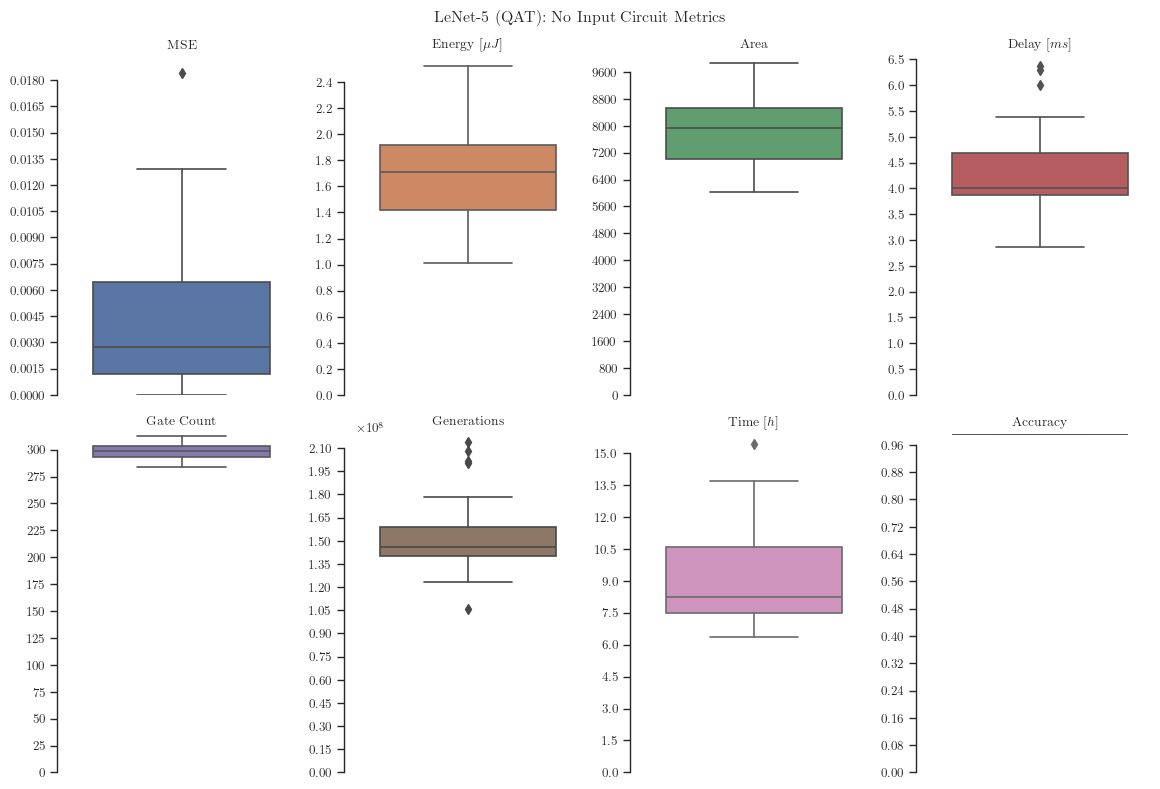

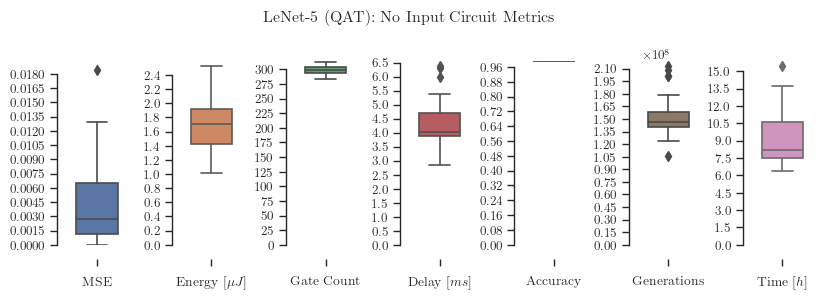

In [4]:
sns.set_theme(context="paper", font="qhv", style="ticks", rc={
    "text.usetex" : True,
})

titles = {
    "Error": r"MSE",
    "Energy": "Energy [$\mu J$]",
    "Area": "Area",
    "Delay": "Delay [$ms$]",
    "Gate Count": "Gate Count",
    "Generation": "Generations",
    "Timestamp": "Time $[h]$",
    "Top-1": "Accuracy",
}

def plot(solutions_df, col, ax, i, sharex_index=True, landscape=False):
    tick_count = min((solutions_df["Gate Count"].max() + 1) // (2 if not landscape else 1), 15)
    if col == "Timestamp":
        solutions_df = solutions_df.groupby(by=["Run"])["Timestamp"].max().reset_index()      
        solutions_df["Timestamp"] = solutions_df["Timestamp"] / 3600  
    g = sns.boxplot(data=solutions_df, y=col, ax=ax, color=sns.color_palette()[i])
    g.yaxis.set_major_locator(plt.MaxNLocator(tick_count, min_n_ticks=10, integer=(col=="Gate Count")))
    g.set_ylim(0)
    if landscape:
        g.set_title(titles[col])
        g.xaxis.set_visible(False)
    else:
        g.set(xlabel=titles[col])
    g.set_ylabel(None)
    # g.tick_params(axis="x", rotation=90)
    return g      

def plot_columns(df, columns, r, c, sharex=True, landscape=False):
    fig, axes = plt.subplots(r, c, figsize=(8.27 if not landscape else 11.69, 3 * r if not landscape else 8))
    for col, ax, i in zip(columns, axes.flat, range(r*c)):
        plot(df, col, ax, i, c if sharex else 0, landscape=landscape)    
    return fig

for x in ["best"]:
    solutions_df = df if df is not None else load_dfs(best_solution= x == "best", model_acc=True, unique=True)
    fig_all = plot_columns(solutions_df, fitness_columns + ["Generation", "Timestamp", "Top-1"], 2, 4, landscape=True)
    fig_all.suptitle("LeNet-5 (QAT): No Input Circuit Metrics")
    sns.despine(offset=10, bottom=False, left=False, trim=True, fig=fig_all)
    fig_all.tight_layout()
    fig_all.savefig(figures / f"boxplot.{x}.png")
    fig_all.savefig(figures / f"boxplot.{x}.pdf")
    fig_all.savefig(figures / f"boxplot.{x}.svg")

    fig_brief = plot_columns(solutions_df, ["Error", "Energy", "Gate Count", "Delay", "Top-1", "Generation", "Timestamp"], 1, 7, sharex=False)
    sns.despine(offset=10, bottom=False, left=False, trim=True, fig=fig_brief)
    fig_brief.suptitle("LeNet-5 (QAT): No Input Circuit Metrics")
    fig_brief.tight_layout()
    fig_brief.savefig(figures / f"boxplot_{x}_brief.png")
    fig_brief.savefig(figures / f"boxplot_{x}_brief.pdf")
    fig_brief.savefig(figures / f"boxplot_{x}_brief.svg")

In [5]:
solutions_df = load_dfs(best_solution=True, model_acc=True)
non_duplicate_df = load_dfs(best_solution=True, model_acc=True, unique=True)
solutions_df["Accuracy Loss"] = (solutions_df["Ref Top-1"] - solutions_df["Top-1"]) * 100
solutions_df["Loss Delta"] = solutions_df["Ref Loss"] - solutions_df["Loss"]
solutions_df["Dataset Split"] = solutions_df["Dataset"].apply(lambda x: x.split(",")[1].strip())

In [6]:
def plot_pareto(title: str = None, layer_index: int = None, epsilon_a = 0.197, epsilon_e = 1e-5, fig=None, ax=None):
    assert fig == ax == None or fig != None and ax != None
    
    temp_df = solutions_df
    pareto = is_pareto_efficient_simple(np.vstack((temp_df["Accuracy Loss"], temp_df["Energy"])).T)
    scatter_df = temp_df.copy()
    scatter_df["Accuracy Loss"] += epsilon_a
    scatter_df["Energy"] += epsilon_e

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8.27, 3.65))

    sns.lineplot(data=scatter_df.loc[pareto, :], x="Energy", y="Accuracy Loss", linestyle="--", color="#555", lw=0.7, alpha=0.6, ax=ax)
    g = sns.scatterplot(data=scatter_df, x="Energy", y="Accuracy Loss", hue="MSE Threshold", style="Dataset Split", s=15, palette=sns.color_palette(), ax=ax)
    g.set(yscale="log", xscale="log", xlabel=r"Energy $[\mu J] + \varepsilon$", ylabel=r"Accuracy Loss $[$\%$] + \varepsilon$")
    if title:
        g.set_title(title)
    g.legend(loc="center left", bbox_to_anchor=(1.1, 0.5), ncol=1)
    sns.despine()
    return temp_df[["Accuracy Loss", "Energy"]].min()    

C:\Users\Majo\AppData\Local\Temp\ipykernel_19084\1790176982.py:10: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  g = sns.swarmplot(data=solutions_df, x="MSE Threshold", y="Accuracy Loss", hue="Dataset Split", dodge=False, ax=ax[0], palette=sns.color_palette(), size=3)
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated an

x = [0]
x = |1|
y = |238|
same = |1|
y = [-127 -126 -124 -123 -122 -120 -119 -118 -116 -115 -112 -111 -110 -107
 -106 -105 -104 -103 -102 -101  -99  -98  -96  -95  -94  -93  -92  -91
  -90  -89  -88  -87  -86  -85  -84  -83  -82  -81  -80  -79  -78  -77
  -76  -75  -74  -73  -72  -71  -70  -69  -68  -67  -66  -65  -64  -63
  -62  -61  -60  -59  -58  -57  -56  -55  -54  -53  -52  -51  -50  -49
  -48  -47  -46  -45  -44  -43  -42  -41  -40  -39  -38  -37  -36  -35
  -34  -33  -32  -31  -30  -29  -28  -27  -26  -25  -24  -23  -22  -21
  -20  -19  -18  -17  -16  -15  -14  -13  -12  -11  -10   -9   -8   -7
   -6   -5   -4   -3   -2   -1    0    1    2    3    4    5    6    7
    8    9   10   11   12   13   14   15   16   17   18   19   20   21
   22   23   24   25   26   27   28   29   30   31   32   33   34   35
   36   37   38   39   40   41   42   43   44   45   46   47   48   49
   50   51   52   53   54   55   56   57   58   59   60   61   62   63
   64   65   66   67   68   69   70 

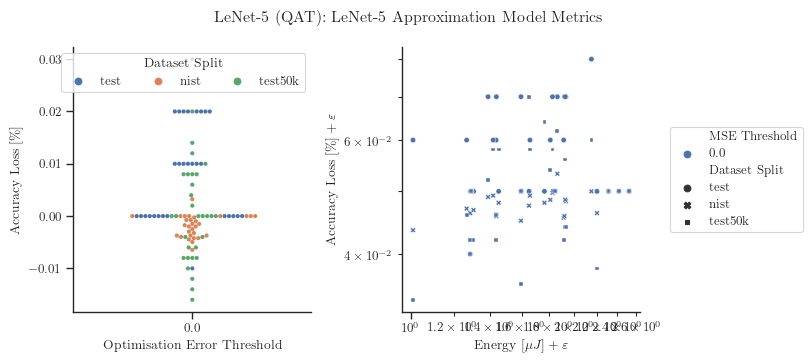

In [7]:

sns.set_theme(context="paper", font="qhv", style="ticks", rc={
    "text.usetex" : True,
})

fig, ax = plt.subplots(1, 2, figsize=(8.27, 3.65))
ax = ax.flat

# solutions_df["Approximate Error"] = 10 ** (np.round(np.emath.logn(10, solutions_df["Error"])))

g = sns.swarmplot(data=solutions_df, x="MSE Threshold", y="Accuracy Loss", hue="Dataset Split", dodge=False, ax=ax[0], palette=sns.color_palette(), size=3)
g.set(xlabel=r"Optimisation Error Threshold", ylabel=r"Accuracy Loss [$\%$]")
g.legend(loc="best", ncol=3, title="Dataset Split")

plot_pareto(epsilon_a=0.05, epsilon_e=1e-5, ax=ax[1], fig=fig)

fig.suptitle("LeNet-5 (QAT): LeNet-5 Approximation Model Metrics")
fig.tight_layout()
fig.savefig(figures / "model.metrics.pdf")
solutions_df[["Accuracy Loss", "Energy"]].min()

x, y = get_weights()
print(f"x = {np.unique(x)}")
print(f"x = |{len(np.unique(x))}|")
print(f"y = |{len(np.unique(y))}|")
print(f"same = |{len(np.intersect1d(x, y, assume_unique=False))}|")
print(f"y = {np.unique(y)}")
print(f"same = {np.intersect1d(x, y, assume_unique=False)}")

### Function Energy Overview and Usage

warn: [Errno 2] No such file or directory: 'C:\\Users\\Majo\\source\\repos\\TorchCompresser\\data_store\\le_selector\\figures\\train_cgp.config'
warn: [Errno 2] No such file or directory: 'C:\\Users\\Majo\\source\\repos\\TorchCompresser\\data_store\\le_selector\\model_metrics\\train_cgp.config'
warn: [Errno 2] No such file or directory: 'C:\\Users\\Majo\\source\\repos\\TorchCompresser\\data_store\\le_selector\\figures\\train_cgp.config'
warn: [Errno 2] No such file or directory: 'C:\\Users\\Majo\\source\\repos\\TorchCompresser\\data_store\\le_selector\\model_metrics\\train_cgp.config'


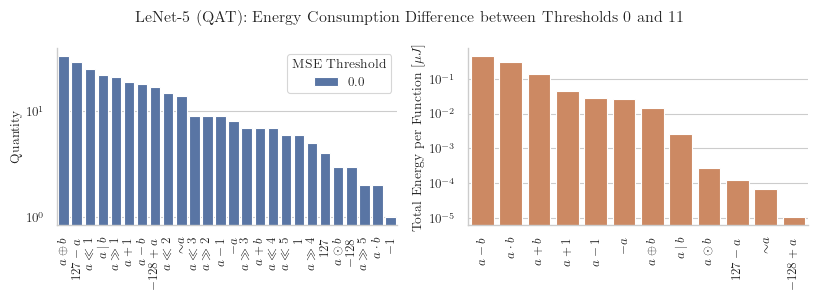

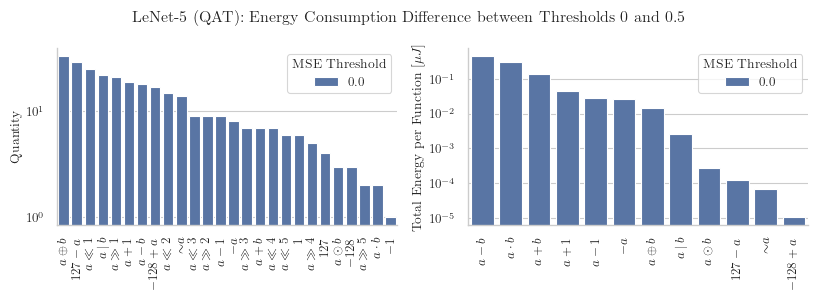

In [8]:


thresholds = solutions_df["MSE Threshold"].unique()

best_solutions = []

for i, threshold in enumerate(sorted(thresholds)):
    best_solution = solutions_df.loc[(solutions_df["Accuracy Loss"] <= 0) & (solutions_df["MSE Threshold"] == threshold), :].sort_values(by=["Energy", "Accuracy Loss"], ascending=[True, True]).iloc[0]
    best_gate_df = get_gate_statistics(record=best_solution).sort_values(by="Quantity")
    best_gate_df["MSE Threshold"] = float(threshold)
    best_solutions.append(best_gate_df)

plot_df = pd.concat(best_solutions)
# plot_df["MSE Threshold"] = plot_df["MSE Threshold"].astype(str)
sns.set_theme(context="paper", font="qhv", style="whitegrid", rc={
    "text.usetex" : True,
})

def plot_pair(ax, *groups, energy_legend=False):
    group = plot_df.loc[plot_df["MSE Threshold"].isin(groups), :]
    group["MSE Threshold"] = group["MSE Threshold"].astype(str)

    quantity_df = group.loc[group["Quantity"] > 0, :].sort_values(by=["Quantity"], ascending=False)
    energy_df = group.loc[group["Energy"] > 0, :].sort_values(by=["Energy"], ascending=False)

    g = sns.barplot(data=quantity_df, x="Function Name", y="Quantity", hue="MSE Threshold", ax=ax[0], dodge=False)
    g.set(xlabel=None, yscale="log")
    sns.move_legend(g, "upper right")
    
    if not energy_legend:
        g = sns.barplot(data=energy_df, x="Function Name", y="Energy", color=sns.color_palette()[1], ax=ax[1], dodge=False)
    else:
        g = sns.barplot(data=energy_df, x="Function Name", y="Energy", hue="MSE Threshold", ax=ax[1], dodge=False)
    g.set(xlabel=None, yscale="log", ylabel=r"Total Energy per Function [$\mu J$]")

    

fig, ax = plt.subplots(1, 2, figsize=(8.27, 3))

plot_pair(ax, 11, 0)
for i, ax in enumerate(fig.axes):
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
fig.suptitle("LeNet-5 (QAT): Energy Consumption Difference between Thresholds 0 and 11")
sns.despine()
fig.tight_layout()
fig.savefig(figures / "energy_consumption_11_0.pdf")

fig, ax = plt.subplots(1, 2, figsize=(8.27, 3))

plot_pair(ax, 0.5, 0, energy_legend=True)
for i, ax in enumerate(fig.axes):
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
fig.suptitle("LeNet-5 (QAT): Energy Consumption Difference between Thresholds 0 and 0.5")
sns.despine()
fig.tight_layout()
fig.savefig(figures / "energy_consumption_0.5_0.pdf")
